In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
from datetime import datetime

# Reproducibility
RANDOM_STATE = 42

# Output folders
pathlib.Path("artifacts_dt").mkdir(exist_ok=True)

In [2]:
# Load dataset
df = pd.read_csv(r"C:\Users\ztech.pk\Documents\Car_Price_Prediction.csv")

In [3]:
df

,Make,Model,Year,Engine Size,Mileage,Fuel Type,Transmission,Price
0,Honda,Model B,2015,3.9,74176,Petrol,Manual,30246.207931
1,Ford,Model C,2014,1.7,94799,Electric,Automatic,22785.747684
2,BMW,Model B,2006,4.1,98385,Electric,Manual,25760.290347
3,Honda,Model B,2015,2.6,88919,Electric,Automatic,25638.003491
4,Honda,Model C,2004,3.4,138482,Petrol,Automatic,21021.386657
...,...,...,...,...,...,...,...,...
995,Toyota,Model D,2002,1.9,5445,Petrol,Manual,22765.597091
996,Honda,Model B,2020,3.1,149112,Diesel,Manual,30392.575567
997,Ford,Model C,2008,1.9,195387,Petrol,Automatic,16446.892292
998,Toyota,Model A,2003,4.4,246,Petrol,Automatic,27396.156708


In [5]:
# Display first 5 rows
df.head()

,Make,Model,Year,Engine Size,Mileage,Fuel Type,Transmission,Price
0,Honda,Model B,2015,3.9,74176,Petrol,Manual,30246.207931
1,Ford,Model C,2014,1.7,94799,Electric,Automatic,22785.747684
2,BMW,Model B,2006,4.1,98385,Electric,Manual,25760.290347
3,Honda,Model B,2015,2.6,88919,Electric,Automatic,25638.003491
4,Honda,Model C,2004,3.4,138482,Petrol,Automatic,21021.386657


# Data cleaning & preprocessing

In [8]:
# Dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Make          1000 non-null   object 
 1   Model         1000 non-null   object 
 2   Year          1000 non-null   int64  
 3   Engine Size   1000 non-null   float64
 4   Mileage       1000 non-null   int64  
 5   Fuel Type     1000 non-null   object 
 6   Transmission  1000 non-null   object 
 7   Price         1000 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 62.6+ KB


In [9]:
# Check missing values
df.isnull().sum()

Make            0
Model           0
Year            0
Engine Size     0
Mileage         0
Fuel Type       0
Transmission    0
Price           0
dtype: int64

In [10]:
# Check duplicates
print("Duplicates before:", df.duplicated().sum())

Duplicates before: 0


In [11]:
# Drop duplicates
df = df.drop_duplicates()

print("Duplicates after:", df.duplicated().sum())

Duplicates after: 0


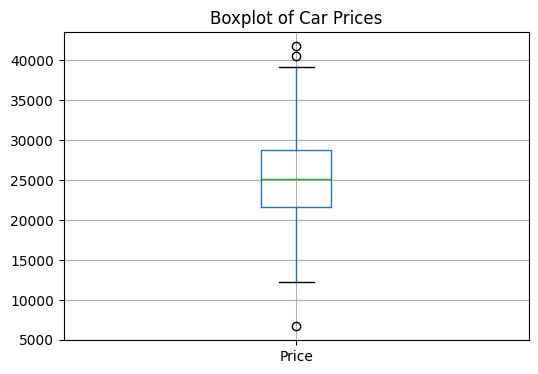

In [12]:
# Boxplot for Price
plt.figure(figsize=(6,4))
df.boxplot(column="Price")
plt.title("Boxplot of Car Prices")
plt.show()

In [15]:
#Outlier exploration (IQR for numeric features)
numeric_cols = ["Year", "Engine Size", "Mileage", "Price"]

def iqr_bounds(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return lower, upper

for col in numeric_cols:
    low, up = iqr_bounds(df[col])
    outliers = ((df[col] < low) | (df[col] > up)).sum()
    print(f"{col}: lower={low:.2f}, upper={up:.2f}, outliers={outliers}")

Year: lower=-3.53, upper=3.47, outliers=0
Engine Size: lower=-3.52, upper=3.52, outliers=0
Mileage: lower=-3.51, upper=3.50, outliers=0
Price: lower=10760.14, upper=39634.10, outliers=3


In [16]:
# Winsorize (cap) outliers for numeric columns (except Year which is categorical-like numeric)
from scipy.stats.mstats import winsorize

df["Engine Size"] = pd.Series(winsorize(df["Engine Size"], limits=(0.01, 0.01)))
df["Mileage"] = pd.Series(winsorize(df["Mileage"], limits=(0.01, 0.01)))
df["Price"] = pd.Series(winsorize(df["Price"], limits=(0.01, 0.01)))


In [50]:
# Categorical encoding plan (One-Hot Encoding)
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Define target and feature columns
target = "Price"
categorical_cols = ["Make", "Model", "Fuel Type", "Transmission"]
feature_cols = ["Year", "Engine Size", "Mileage"] + categorical_cols

# Separate features and target
X = df[feature_cols].copy()
y = df[target].copy()

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("Encoded feature shape:", X_encoded.shape)
X_encoded.head()


Encoded feature shape: (1000, 14)


,Year,Engine Size,Mileage,Make_BMW,Make_Ford,Make_Honda,Make_Toyota,Model_Model B,Model_Model C,Model_Model D,Model_Model E,Fuel Type_Electric,Fuel Type_Petrol,Transmission_Manual
0,0.686031,1.076274,-0.387368,False,False,True,False,True,False,False,False,False,True,True
1,0.526933,-1.072952,-0.040282,False,True,False,False,False,True,False,False,True,False,False
2,-0.745852,1.271658,0.020070,True,False,False,False,True,False,False,False,True,False,True
3,0.686031,-0.193723,-0.139243,False,False,True,False,True,False,False,False,True,False,False
4,-1.064048,0.587813,0.694904,False,False,True,False,False,True,False,False,False,True,False


# EDA and visualization

In [18]:
# Ensure Price is numeric
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

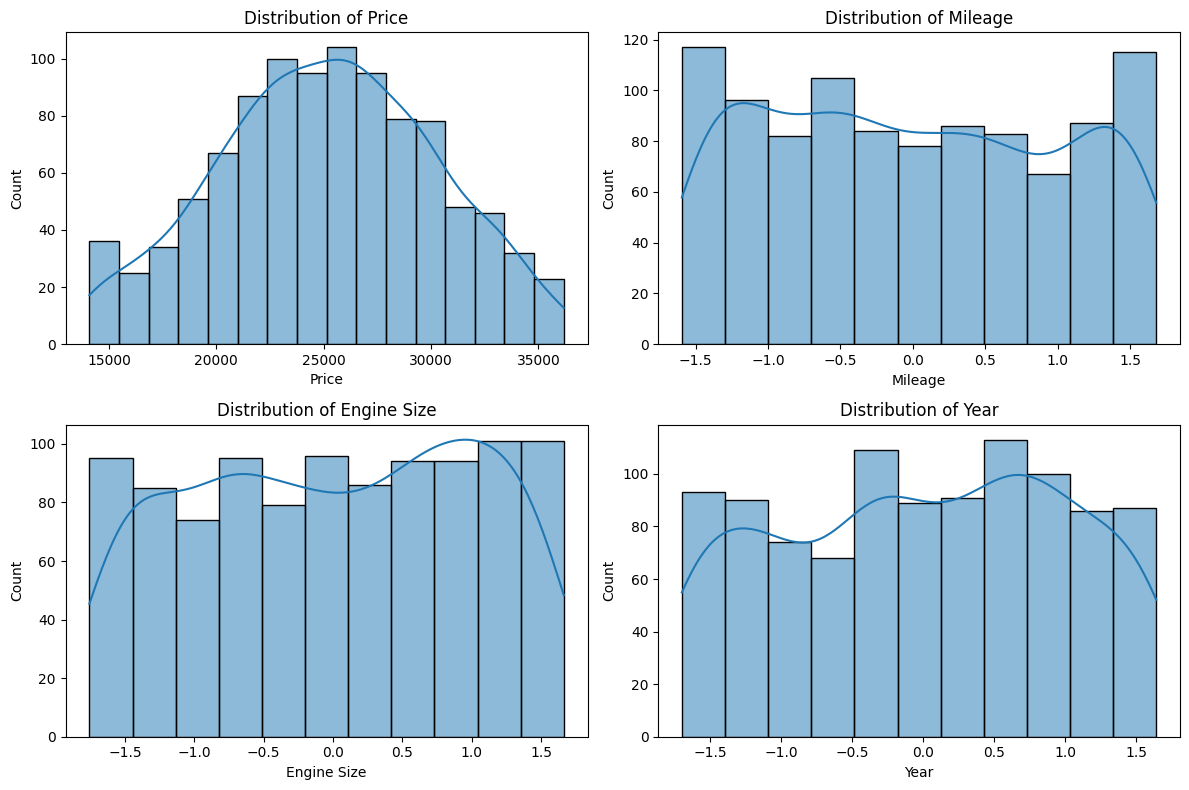

In [19]:
#Histograms for key numeric features
plt.figure(figsize=(12, 8))
for i, col in enumerate(["Price", "Mileage", "Engine Size", "Year"], 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

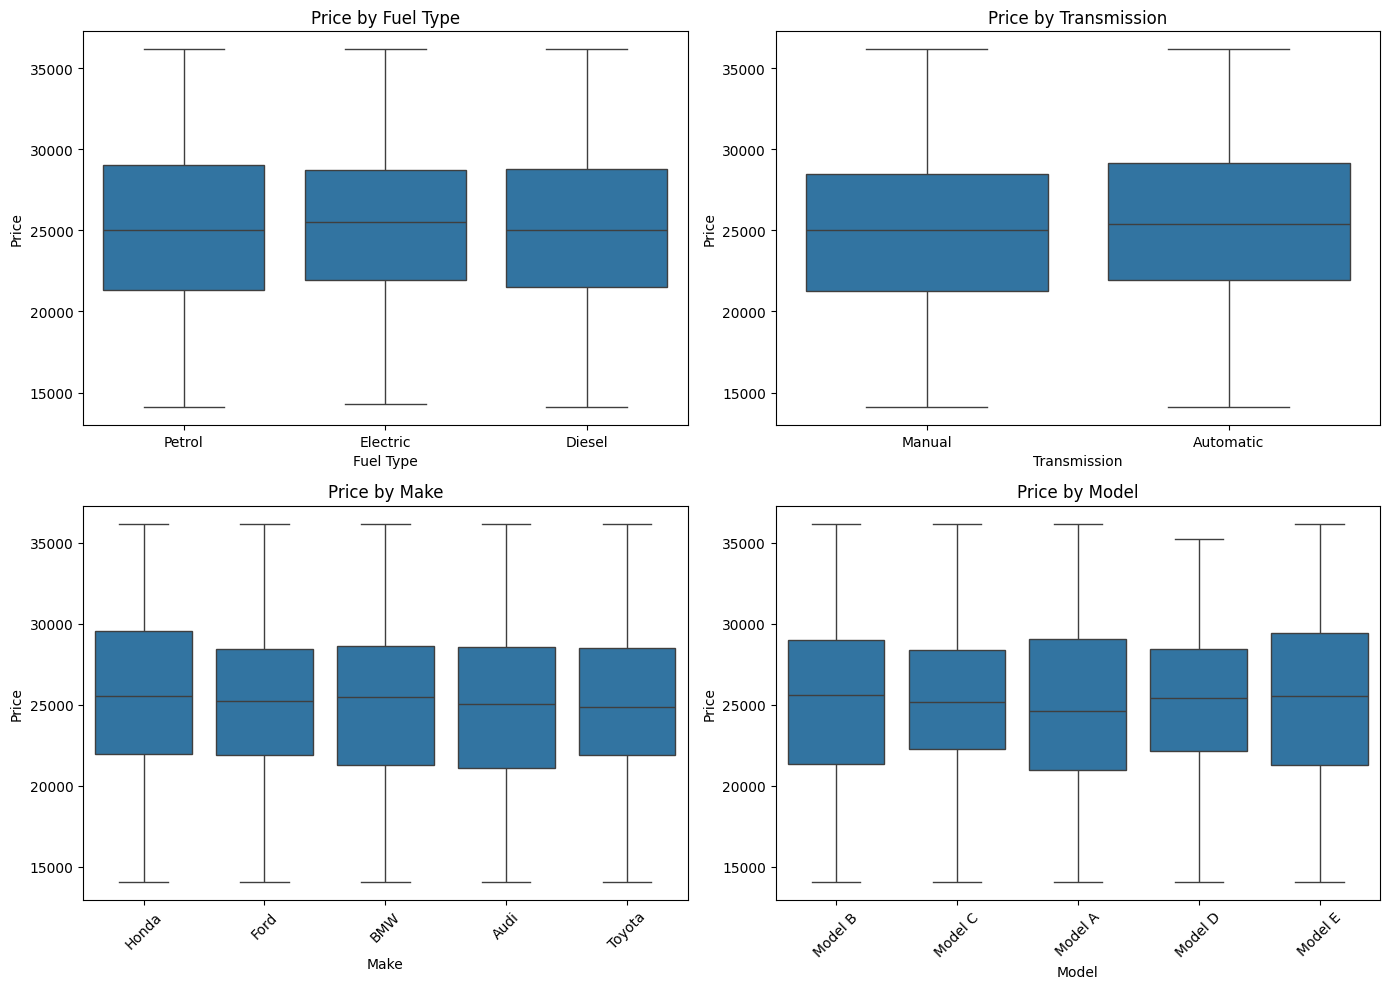

In [20]:
#Boxplots to compare price across categories

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x="Fuel Type", y="Price", data=df)
plt.title("Price by Fuel Type")

plt.subplot(2, 2, 2)
sns.boxplot(x="Transmission", y="Price", data=df)
plt.title("Price by Transmission")

plt.subplot(2, 2, 3)
sns.boxplot(x="Make", y="Price", data=df)
plt.title("Price by Make")
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
sns.boxplot(x="Model", y="Price", data=df)
plt.title("Price by Model")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

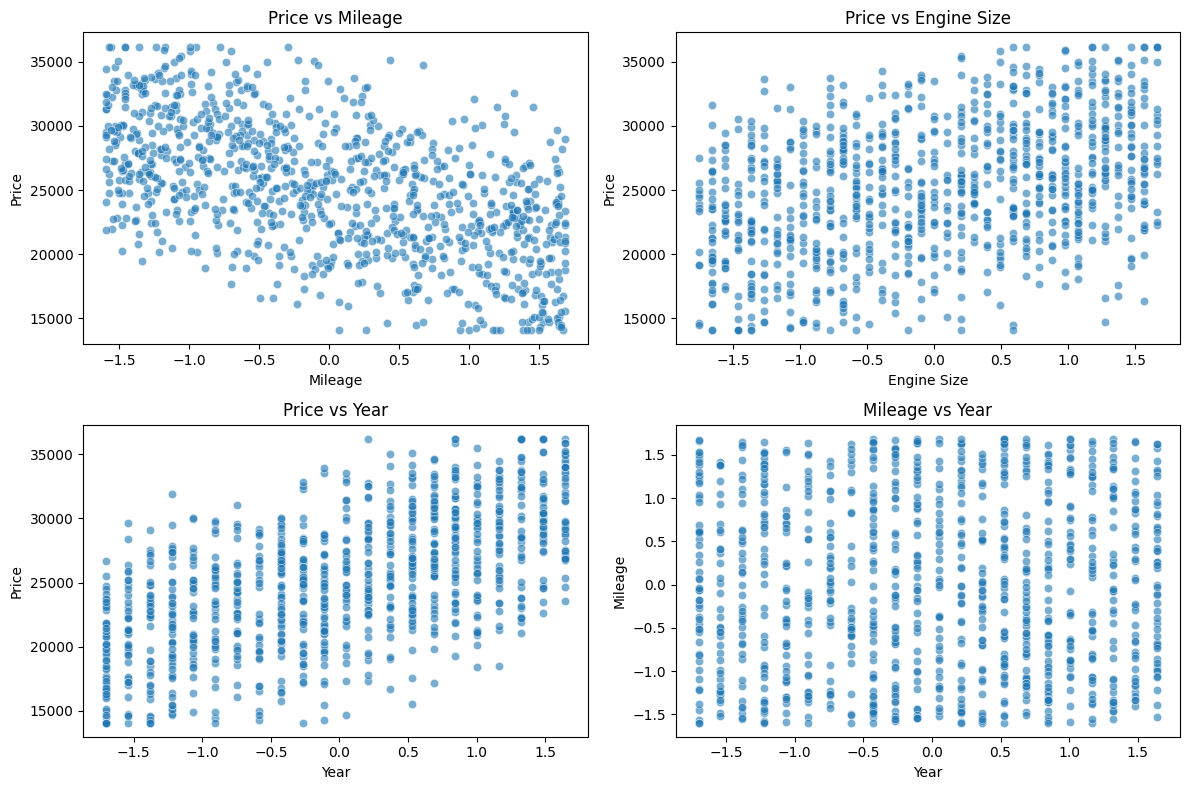

In [21]:
#Scatter plots to inspect relationships with price

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.scatterplot(x="Mileage", y="Price", data=df, alpha=0.6)
plt.title("Price vs Mileage")

plt.subplot(2, 2, 2)
sns.scatterplot(x="Engine Size", y="Price", data=df, alpha=0.6)
plt.title("Price vs Engine Size")

plt.subplot(2, 2, 3)
sns.scatterplot(x="Year", y="Price", data=df, alpha=0.6)
plt.title("Price vs Year")

plt.subplot(2, 2, 4)
sns.scatterplot(x="Year", y="Mileage", data=df, alpha=0.6)
plt.title("Mileage vs Year")

plt.tight_layout()
plt.show()

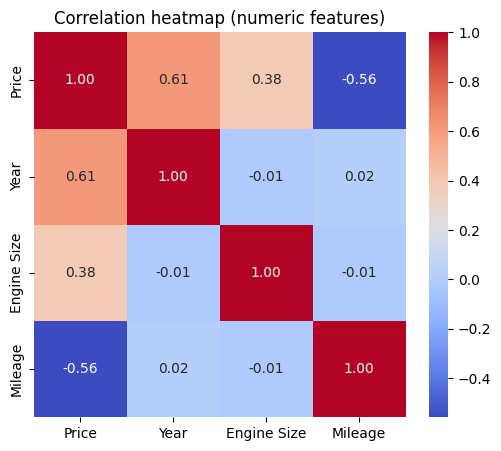

In [22]:
#Correlation heatmap for numeric features

# Select numeric subset
num_df = df[["Price", "Year", "Engine Size", "Mileage"]]

plt.figure(figsize=(6, 5))
sns.heatmap(num_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation heatmap (numeric features)")
plt.show()

In [23]:
# Feature engineering (create Age and Mileage_per_year)
current_year = 2025  # as of your timeline
df["Age"] = current_year - df["Year"]
# Avoid division by zero: if Age=0, set mileage per year to mileage (acts as proxy)
df["Mileage_per_year"] = df["Mileage"] / df["Age"].replace(0, 1)

df.head()

,Make,Model,Year,Engine Size,Mileage,Fuel Type,Transmission,Price,Age,Mileage_per_year
0,Honda,Model B,0.686031,1.076274,-0.387368,Petrol,Manual,30246.207931,2024.313969,-0.000191
1,Ford,Model C,0.526933,-1.072952,-0.040282,Electric,Automatic,22785.747684,2024.473067,-0.000020
2,BMW,Model B,-0.745852,1.271658,0.020070,Electric,Manual,25760.290347,2025.745852,0.000010
3,Honda,Model B,0.686031,-0.193723,-0.139243,Electric,Automatic,25638.003491,2024.313969,-0.000069
4,Honda,Model C,-1.064048,0.587813,0.694904,Petrol,Automatic,21021.386657,2026.064048,0.000343


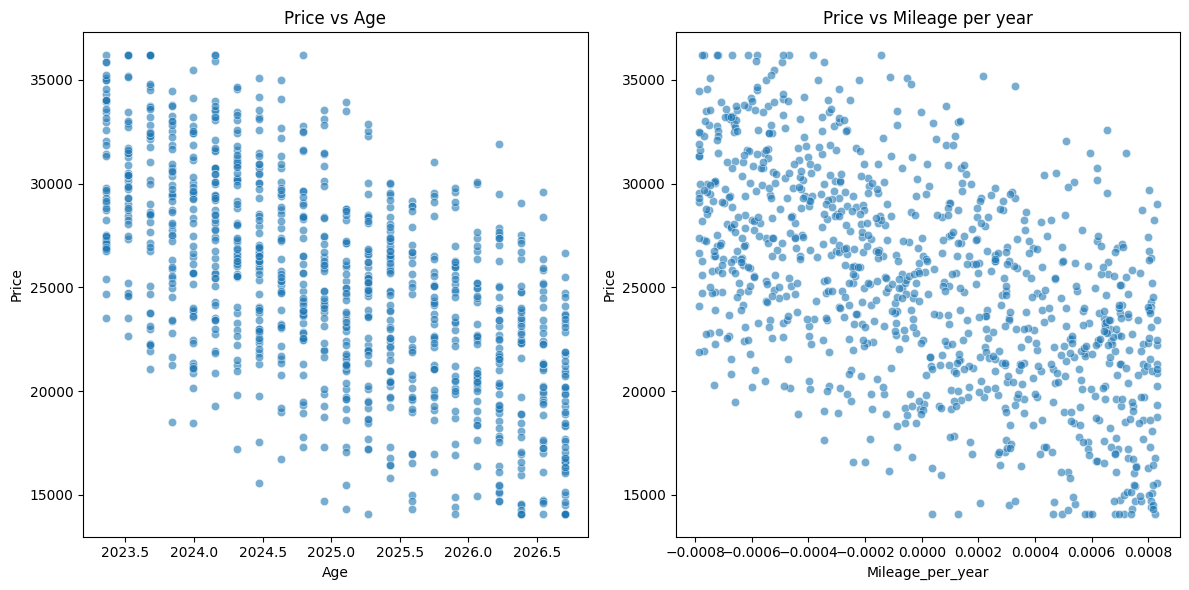

In [24]:
#Visualize engineered features against price

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x="Age", y="Price", data=df, alpha=0.6)
plt.title("Price vs Age")

plt.subplot(1, 2, 2)
sns.scatterplot(x="Mileage_per_year", y="Price", data=df, alpha=0.6)
plt.title("Price vs Mileage per year")

plt.tight_layout()
plt.show()

In [25]:
#Transform or remove features based on insights

# Example decisions (adjust to your EDA findings):

# 1) If 'Model' has very high cardinality with sparse categories, consider limiting to top N and grouping others
top_models = df["Model"].value_counts().nlargest(10).index
df["Model_grouped"] = np.where(df["Model"].isin(top_models), df["Model"], "Other")

# 2) If 'Year' is now redundant after adding 'Age', you may drop 'Year' to reduce multicollinearity
# Keep 'Year' if you plan tree-based models only (they handle it fine); drop for linear models if needed.
df_reduced = df.drop(columns=["Year"])  # optional; keep a copy with reduced features

# 3) Prepare final feature set for modeling (one-hot encode categories)
cat_cols_fe = ["Make", "Model_grouped", "Fuel Type", "Transmission"]
num_cols_fe = ["Engine Size", "Mileage", "Age", "Mileage_per_year"]  # can include logs if beneficial

df_model = pd.get_dummies(df_reduced[cat_cols_fe + num_cols_fe + ["Price"]],
                          columns=cat_cols_fe, drop_first=True)

df_model.head()

,Engine Size,Mileage,Age,Mileage_per_year,Price,Make_BMW,Make_Ford,Make_Honda,Make_Toyota,Model_grouped_Model B,Model_grouped_Model C,Model_grouped_Model D,Model_grouped_Model E,Fuel Type_Electric,Fuel Type_Petrol,Transmission_Manual
0,1.076274,-0.387368,2024.313969,-0.000191,30246.207931,False,False,True,False,True,False,False,False,False,True,True
1,-1.072952,-0.040282,2024.473067,-0.000020,22785.747684,False,True,False,False,False,True,False,False,True,False,False
2,1.271658,0.020070,2025.745852,0.000010,25760.290347,True,False,False,False,True,False,False,False,True,False,True
3,-0.193723,-0.139243,2024.313969,-0.000069,25638.003491,False,False,True,False,True,False,False,False,True,False,False
4,0.587813,0.694904,2026.064048,0.000343,21021.386657,False,False,True,False,False,True,False,False,False,True,False


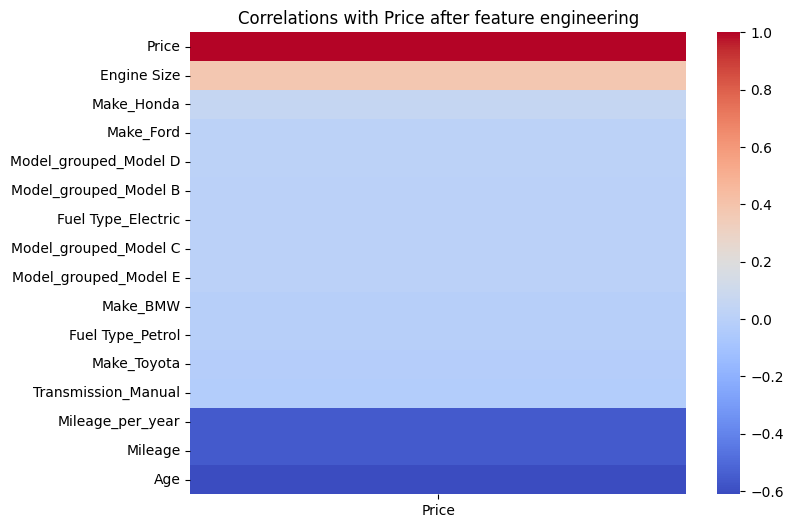

In [26]:
#Quick correlation check with engineered features

plt.figure(figsize=(8, 6))
sns.heatmap(df_model.corr()[["Price"]].sort_values("Price", ascending=False),
            cmap="coolwarm", annot=False)
plt.title("Correlations with Price after feature engineering")
plt.show()

# Model training (Random Forest)

In [28]:
#Define features, target, and train–test split

from sklearn.model_selection import train_test_split

# Final feature lists
num_cols_fe = ["Engine Size", "Mileage", "Age", "Mileage_per_year"]
cat_cols_fe = ["Make", "Model", "Fuel Type", "Transmission"]  # <-- use "Model" not "Model_grouped"

# Target
target = "Price"

In [29]:
# Keep only necessary columns for modeling
cols_for_model = num_cols_fe + cat_cols_fe + [target]
data = df[cols_for_model].copy()

In [30]:
# Train/test split (hold-out test set for unbiased evaluation)
X = data.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((800, 8), (200, 8))

In [33]:
#Build preprocessing pipeline (imputation, scaling, one-hot)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [39]:
#Preprocessing pipeline
categorical_cols = ["Make", "Model", "Fuel Type", "Transmission"]
numeric_cols = ["Year", "Engine Size", "Mileage", "Age", "Mileage_per_year"]

X = df[numeric_cols + categorical_cols].copy()
y = df["Price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
    ]
)

# Random Forest pipeline
rf_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1)),
])

In [40]:
#Define model

rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

In [43]:
# Hyperparameter grids

param_grid = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 10],
    "model__min_samples_leaf": [1, 5],
    "model__max_features": ["sqrt", "log2", None],
    "model__bootstrap": [True],
}

#Train with cross-validation using Pipelines and GridSearchCV

grid_rf = GridSearchCV(
    rf_pipe,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Best params:", grid_rf.best_params_)


Best params: {'model__bootstrap': True, 'model__max_depth': 10, 'model__max_features': None, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 400}


# Model evaluation & selection

In [44]:
# Evaluate Random Forest on test set
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Best model from GridSearchCV
best_rf = grid_rf.best_estimator_

# Predict on test set
y_pred = best_rf.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)   # returns MSE
rmse = np.sqrt(mse)                        # take square root manually
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest Performance on Test Set:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")

Random Forest Performance on Test Set:
RMSE: 2279.33
MAE: 1848.50
R²: 0.808


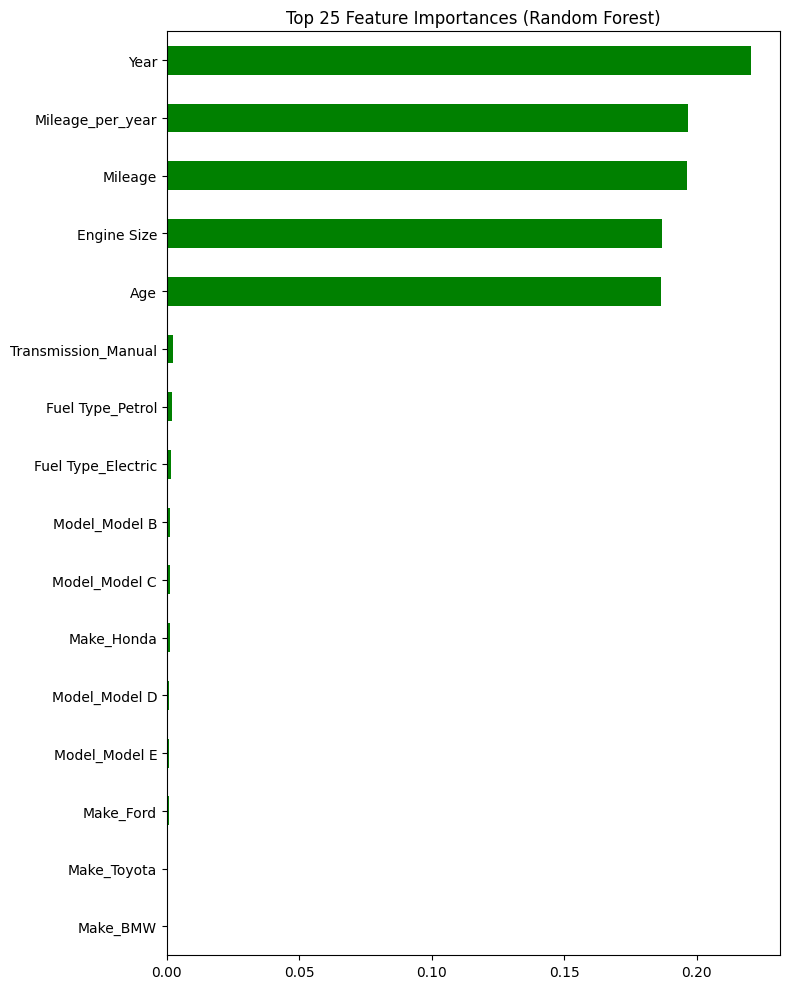

In [45]:
# Extract trained Random Forest from pipeline
rf_model = best_rf.named_steps["model"]

# Get feature names from preprocessor
preprocessor = best_rf.named_steps["preprocessor"]
num_features = preprocessor.transformers_[0][2]
cat_features = preprocessor.transformers_[1][1].get_feature_names_out(preprocessor.transformers_[1][2])
feature_names = list(num_features) + list(cat_features)

# Build importance series and plot
importances = pd.Series(rf_model.feature_importances_, index=feature_names).sort_values(ascending=False)

importances.head(25).plot(kind="barh", figsize=(8,10), color="green")
plt.title("Top 25 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Error analysis & improvement

In [48]:
# Error analysis for Random Forest

import pandas as pd

errors = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred  # predictions from best_rf
})
errors["abs_error"] = (errors["y_true"] - errors["y_pred"]).abs()

# Sort by absolute error
errors_sorted = errors.sort_values("abs_error", ascending=False)

# Show top 10 worst cases
print("Top 10 high-error predictions (Random Forest):")
print(errors_sorted.head(10))

# Save full error table for reporting
errors_sorted.to_csv("artifacts_rf/errors_test.csv", index=False)

# Save in current folder instead of a subfolder
errors_sorted.to_csv("errors_test_rf.csv", index=False)



Top 10 high-error predictions (Random Forest):
           y_true        y_pred    abs_error
15   22235.130084  28958.558361  6723.428277
144  28470.530022  21750.481669  6720.048353
23   28398.167386  22394.212427  6003.954959
117  14089.788408  19189.705090  5099.916682
21   26287.265384  21296.562176  4990.703208
143  24610.467746  29561.028840  4950.561094
105  29066.254419  24781.055675  4285.198744
11   26186.290378  21909.581061  4276.709317
39   21021.269253  25291.946902  4270.677648
116  14742.226324  18965.176542  4222.950218


OSError: Cannot save file into a non-existent directory: 'artifacts_rf'

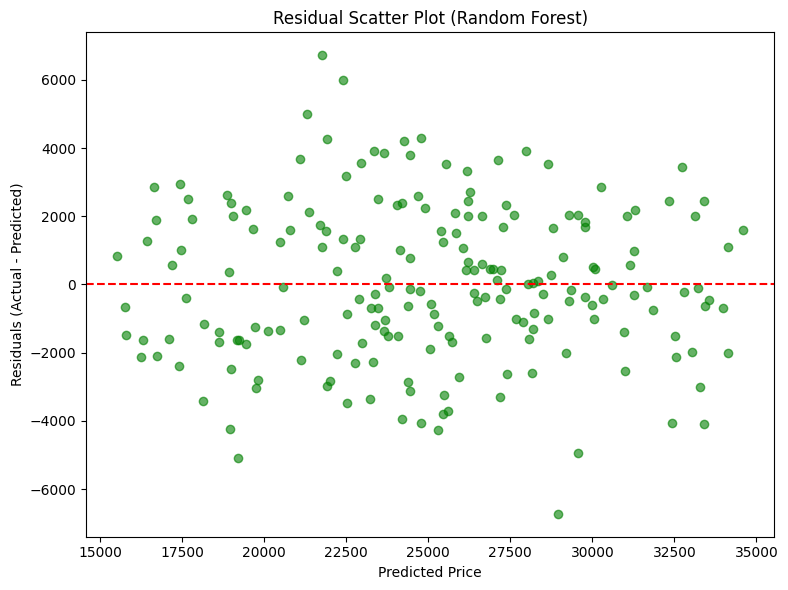

In [49]:
# Residual scatter plot for Random Forest
residuals = y_test - y_pred  # y_pred should come from best_rf.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.6, color="green")
plt.axhline(y=0, color="red", linestyle="--")  # reference line at 0
plt.xlabel("Predicted Price")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Scatter Plot (Random Forest)")
plt.tight_layout()
plt.show()
